# Exercise 2

Required python packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from logging import error, warning, info, basicConfig
from tqdm import tqdm
from numba import njit, jit, prange

In [2]:
np.random.seed(42)
basicConfig(level='INFO')
SAVE_PATH = 'temp_media/ex2'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(SAVE_PATH, exist_ok=True)

Check for CUDA availability for GPU compute

In [3]:
from numba import cuda

CUDA = False

try:
    CUDA = cuda.detect()
    info('CUDA is available.')
except ImportError:
    info('CUDA is not available. Uses CPU for computations instead.')

INFO:root:CUDA is not available. Uses CPU for computations instead.


SOR solver for solving Laplace equation and getting concentration gradients at final iteration

In [56]:
@jit(nopython=True, parallel=True)
def sor_parallel(c, omega, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0] # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        # Red points
        for i in prange(0, Nx):
            for j in range(1, Nx-1): # exclude y=0 sink and y=Nx source
                if (i + j) % 2 == 0:
                    # for periodic boundaries, note use of (i+1)% Nx, i-1 pythonically wraps to index -1
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25 * \
                        (c[(i+1)%Nx, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

        # Black points
        for i in prange(0, Nx):
            for j in range(1, Nx-1):
                if (i + j) % 2 == 1:
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25 * \
                        (c[(i+1)%Nx, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # info(f'Converged after {n} iterations using omega={omega}.')
            break
    
    return c, n, converged


# doesn't work with numba
# def has_converged(c_new, c_old, epsilon) -> bool:
#     '''Check if the SOR solver has converged to a stead state solution.'''
#     return np.max(np.abs(c_new - c_old)) < epsilon


def select_best_omega_for_sor(omega_values, epsilon, c_init, max_iterations=2_000):
    '''Finds the best relaxation parameter omega for SOR'''

    best_omega = 0
    least_iter = max_iterations

    for omega in tqdm(range(omega_values)):
        c = c_init.copy()
        c, n_iter, converged = sor_parallel(c, omega, epsilon, max_iterations)
        if converged and n_iter < least_iter:
            least_iter = n_iter
            best_omega = omega
            c_converged = c.copy()
        else:
            info(f'Convergence not reached for omega={omega}.')
    if best_omega == 0:
        raise ValueError(f'Unable to converge using provided omega values {omega_values} within {max_iterations} steps. Please provide larger omega range and/or maximum iteration count to reach convergence.')
    return c_converged, best_omega, least_iter

def plot_laplace_grid(c, title, filename):
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(c, 3), interpolation='nearest', origin='lower')
    plt.colorbar(label='Concentration')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(f'{SAVE_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

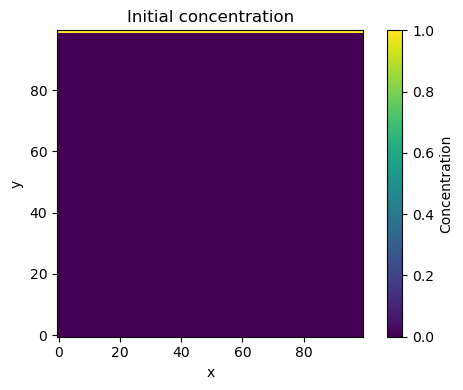

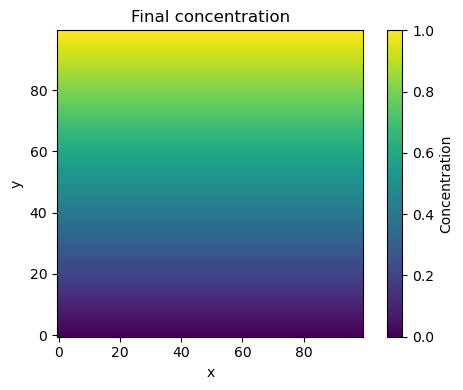

In [57]:
Nx = 100
c = np.zeros((Nx, Nx))
c[:, -1] = 1
c_init = c.copy()
c, iter, converged = sor_parallel(c, 1.5)
plot_laplace_grid(c_init, 'Initial concentration', 'initial_concentration')
plot_laplace_grid(c, 'Final concentration', 'final_concentration')